<a href="https://colab.research.google.com/github/forkedroads/ai_courses/blob/main/smolagents/unit2/tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Agents That Use Code

This notebook is part of the [Hugging Face Agents Course](https://www.hf.co/learn/agents-course), a free Course from beginner to expert, where you learn to build Agents.

![Agents course share](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/communication/share.png)

## Let's install the dependencies and login to our HF account to access the Inference API

If you haven't installed `smolagents` yet, you can do so by running the following command:

In [1]:
!pip install python-dotenv==1.0.1
!pip install google-auth smolagents[litellm]
!pip install llama-index-tools-google llama-index-llms-gemini llama-index-embeddings-gemini
!pip install "smolagents[mcp]"

  Using cached pillow-11.1.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
Using cached pillow-11.1.0-cp311-cp311-manylinux_2_28_x86_64.whl (4.5 MB)
  Attempting uninstall: pillow
    Found existing installation: pillow 10.4.0
    Uninstalling pillow-10.4.0:
      Successfully uninstalled pillow-10.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llama-index-llms-gemini 0.4.14 requires pillow<11.0.0,>=10.2.0, but you have pillow 11.1.0 which is incompatible.


  Using cached pillow-10.4.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.2 kB)
Using cached pillow-10.4.0-cp311-cp311-manylinux_2_28_x86_64.whl (4.5 MB)
  Attempting uninstall: pillow
    Found existing installation: pillow 11.1.0
    Uninstalling pillow-11.1.0:
      Successfully uninstalled pillow-11.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
smolagents 1.13.0 requires pillow<11.2.0,>=11.0.0, but you have pillow 10.4.0 which is incompatible.


  Using cached pillow-11.1.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
Using cached pillow-11.1.0-cp311-cp311-manylinux_2_28_x86_64.whl (4.5 MB)
  Attempting uninstall: pillow
    Found existing installation: pillow 10.4.0
    Uninstalling pillow-10.4.0:
      Successfully uninstalled pillow-10.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llama-index-llms-gemini 0.4.14 requires pillow<11.0.0,>=10.2.0, but you have pillow 11.1.0 which is incompatible.


Let's also login to the Hugging Face Hub to have access to the Inference API.

In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
from smolagents import LiteLLMModel
from dotenv import load_dotenv
import os
from google.colab import userdata


load_dotenv()

# Replace all calls to HfApiModel
llm_model = LiteLLMModel(
    model_id="gemini/gemini-2.0-flash", # you can see other model names here: https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models. It is important to prefix the name with "gemini/"
    api_key=userdata.get('GOOGLE_API_KEY'),
    max_tokens=8192
)

## The `@tool` Decorator  

### Generating a tool that retrieves the highest-rated catering

Let's imagine that Alfred has already decided on the menu for the party, but now he needs help preparing food for such a large number of guests. To do so, he would like to hire a catering service and needs to identify the highest-rated options available. Alfred can leverage a tool to search for the best catering services in his area.

Below is an example of how Alfred can use the `@tool` decorator to make this happen:

In [3]:
from smolagents import CodeAgent, HfApiModel, tool

# Let's pretend we have a function that fetches the highest-rated catering services.
@tool
def catering_service_tool(query: str) -> str:
    """
    This tool returns the highest-rated catering service in Gotham City.

    Args:
        query: A search term for finding catering services.
    """
    # Example list of catering services and their ratings
    services = {
        "Gotham Catering Co.": 4.9,
        "Wayne Manor Catering": 4.8,
        "Gotham City Events": 4.7,
    }

    # Find the highest rated catering service (simulating search query filtering)
    best_service = max(services, key=services.get)

    return best_service


agent = CodeAgent(model = llm_model,
                  tools=[catering_service_tool])

# Run the agent to find the best catering service
result = agent.run(
    "Can you give me the name of the highest-rated catering service in Gotham City?"
)

print(result)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can you give me the name of the highest-rated catering service in Gotham City?                                  │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  catering_service = catering_service_tool(query="highest-rated catering service")                                 
  final_answer(catering_service)                                                                                   
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Gotham Catering Co.

[Step 1: Duration 1.13 seconds| Input tokens: 2,243 | Output tokens: 61]

Gotham Catering Co.


## Defining a Tool as a Python Class  

### Generating a tool to generate ideas about the superhero-themed party

Alfred's party at the mansion is a **superhero-themed event**, but he needs some creative ideas to make it truly special. As a fantastic host, he wants to surprise the guests with a unique theme.

To do this, he can use an agent that generates superhero-themed party ideas based on a given category. This way, Alfred can find the perfect party theme to wow his guests.

In [4]:
from smolagents import Tool, CodeAgent, HfApiModel

class SuperheroPartyThemeTool(Tool):
    name = "superhero_party_theme_generator"
    description = """
    This tool suggests creative superhero-themed party ideas based on a category.
    It returns a unique party theme idea."""

    inputs = {
        "category": {
            "type": "string",
            "description": "The type of superhero party (e.g., 'classic heroes', 'villain masquerade', 'futuristic Gotham').",
        }
    }

    output_type = "string"

    def forward(self, category: str):
        themes = {
            "classic heroes": "Justice League Gala: Guests come dressed as their favorite DC heroes with themed cocktails like 'The Kryptonite Punch'.",
            "villain masquerade": "Gotham Rogues' Ball: A mysterious masquerade where guests dress as classic Batman villains.",
            "futuristic Gotham": "Neo-Gotham Night: A cyberpunk-style party inspired by Batman Beyond, with neon decorations and futuristic gadgets."
        }

        return themes.get(category.lower(), "Themed party idea not found. Try 'classic heroes', 'villain masquerade', or 'futuristic Gotham'.")

# Instantiate the tool
party_theme_tool = SuperheroPartyThemeTool()
agent = CodeAgent(tools=[party_theme_tool], model=llm_model)

# Run the agent to generate a party theme idea
result = agent.run(
    "What would be a good superhero party idea for a 'villain masquerade' theme?"
)

print(result)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ What would be a good superhero party idea for a 'villain masquerade' theme?                                     │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  party_idea = superhero_party_theme_generator(category='villain masquerade')                                      
  final_answer(party_idea)                                                                                         
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Gotham Rogues' Ball: A mysterious masquerade where guests dress as classic Batman villains.

[Step 1: Duration 1.05 seconds| Input tokens: 2,273 | Output tokens: 62]

Gotham Rogues' Ball: A mysterious masquerade where guests dress as classic Batman villains.


## Sharing a Tool to the Hub

Sharing your custom tool with the community is easy! Simply upload it to your Hugging Face account using the `push_to_hub()` method.

For instance, Alfred can share his `catering_service_tool` to help others find the best catering services in Gotham. Here's how to do it:

In [ ]:
party_theme_tool.push_to_hub("{your_username}/catering_service_tool", token="<YOUR_HUGGINGFACEHUB_API_TOKEN>")

## Importing a Tool from the Hub

You can easily import tools created by other users using the `load_tool()` function. For example, Alfred might want to generate a promotional image for the party using AI. Instead of building a tool from scratch, he can leverage a predefined one from the community:

In [5]:
from smolagents import load_tool, CodeAgent, HfApiModel

image_generation_tool = load_tool(
    "m-ric/text-to-image",
    trust_remote_code=True
)

agent = CodeAgent(
    tools=[image_generation_tool],
    model=llm_model
)

agent.run("Generate an image of a luxurious superhero-themed party at Wayne Manor with made-up superheros.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Generate an image of a luxurious superhero-themed party at Wayne Manor with made-up superheros.                 │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  prompt = "A luxurious superhero-themed party at Wayne Manor, with made-up superheroes in attendance. High-res,   
  photorealistic."                                                                                                 
  image = image_generator(prompt=prompt)                                                                           
  final_answer(image)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Code execution failed at line 'image = image_generator(prompt=prompt)' due to: HfHubHTTPError: 402 Client Error: 
Payment Required for url: https://router.huggingface.co/hf-inference/models/black-forest-labs/FLUX.1-schnell 
(Request ID: Root=1-67f2bc36-099ab07449681edc25d6c531;e4e9f2c8-e063-4156-ac2c-eaa5eb436fe1)

You have exceeded your monthly included credits for Inference Providers. Subscribe to PRO to get 20x more monthly 
included credits.

[Step 1: Duration 1.48 seconds| Input tokens: 2,273 | Output tokens: 95]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  prompt = "A superhero party at Wayne Manor, with original superheroes."                                          
  image = image_generator(prompt=prompt)                                                                           
  final_answer(image)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Code execution failed at line 'image = image_generator(prompt=prompt)' due to: HfHubHTTPError: 402 Client Error: 
Payment Required for url: https://router.huggingface.co/hf-inference/models/black-forest-labs/FLUX.1-schnell 
(Request ID: Root=1-67f2bc37-36dc10bc4707a04766e8e899;6fd7b56a-8bcc-43bf-a0de-c8eb0999929d)

You have exceeded your monthly included credits for Inference Providers. Subscribe to PRO to get 20x more monthly 
included credits.

[Step 2: Duration 1.19 seconds| Input tokens: 4,930 | Output tokens: 180]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  prompt = "Cartoon-style superhero party at Wayne Manor, with unique superheroes."                                
  image = image_generator(prompt=prompt)                                                                           
  final_answer(image)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Code execution failed at line 'image = image_generator(prompt=prompt)' due to: HfHubHTTPError: 402 Client Error: 
Payment Required for url: https://router.huggingface.co/hf-inference/models/black-forest-labs/FLUX.1-schnell 
(Request ID: Root=1-67f2bc38-77e668ee62e620396e396ae6;cc771657-4fd1-4c80-b73c-26f5f11fcd5a)

You have exceeded your monthly included credits for Inference Providers. Subscribe to PRO to get 20x more monthly 
included credits.

[Step 3: Duration 1.20 seconds| Input tokens: 7,947 | Output tokens: 267]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("I am unable to generate the requested image due to exceeding my monthly credits for the image      
  generator.")                                                                                                     
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: I am unable to generate the requested image due to exceeding my monthly credits for the image 
generator.

[Step 4: Duration 1.04 seconds| Input tokens: 11,331 | Output tokens: 338]

'I am unable to generate the requested image due to exceeding my monthly credits for the image generator.'

## Importing a Hugging Face Space as a Tool

You can also import a HF Space as a tool using `Tool.from_space()`. This opens up possibilities for integrating with thousands of spaces from the community for tasks from image generation to data analysis.

The tool will connect with the spaces Gradio backend using the `gradio_client`, so make sure to install it via `pip` if you don't have it already. For the party, Alfred can also use a HF Space directly for the generation of the previous annoucement AI-generated image. Let's build it!

In [6]:
!pip install gradio_client

In [7]:
from smolagents import CodeAgent, HfApiModel, Tool

image_generation_tool = Tool.from_space(
    "black-forest-labs/FLUX.1-schnell",
    name="image_generator",
    description="Generate an image from a prompt"
)

model = HfApiModel("Qwen/Qwen2.5-Coder-32B-Instruct")

agent = CodeAgent(tools=[image_generation_tool], model=llm_model)

agent.run(
    "Improve this prompt, then generate an image of it.",
    additional_args={'user_prompt': 'A grand superhero-themed party at Wayne Manor, with Alfred overseeing a luxurious gala'}
)

Loaded as API: https://black-forest-labs-flux-1-schnell.hf.space ✔


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Improve this prompt, then generate an image of it.                                                              │
│ You have been provided with these additional arguments, that you can access using the keys as variables in your │
│ python code:                                                                                                    │
│ {'user_prompt': 'A grand superhero-themed party at Wayne Manor, with Alfred overseeing a luxurious gala'}.      │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  improved_prompt = "A grand superhero-themed gala at Wayne Manor, with Alfred meticulously overseeing the         
  luxurious event. Batman, Superman, Wonder Woman, and The Flash are mingling with other guests, dressed in        
  elegant formal wear with subtle superhero motifs. The manor is lavishly decorated with superhero emblems,        
  banners, and projections. The atmosphere is festive, with upbeat music and dazzling displays of lights and       
  special effects. The scene captures the glamour and excitement of a high-society superhero gathering."           
  print(improved_prompt)                                                                                           
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
A grand superhero-themed gala at Wayne Manor, with Alfred meticulously overseeing the luxurious event. Batman, 
Superman, Wonder Woman, and The Flash are mingling with other guests, dressed in elegant formal wear with subtle 
superhero motifs. The manor is lavishly decorated with superhero emblems, banners, and projections. The atmosphere 
is festive, with upbeat music and dazzling displays of lights and special effects. The scene captures the glamour 
and excitement of a high-society superhero gathering.

Out: None

[Step 1: Duration 1.87 seconds| Input tokens: 2,269 | Output tokens: 162]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  image = image_generator(prompt=improved_prompt)                                                                  
  final_answer(image)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: /tmp/gradio/c200de34262db9ae45090488dd2d81451599b9cfbb3219ed3cb33f6f5658778e/image.webp

[Step 2: Duration 7.17 seconds| Input tokens: 4,958 | Output tokens: 219]

'/tmp/gradio/c200de34262db9ae45090488dd2d81451599b9cfbb3219ed3cb33f6f5658778e/image.webp'

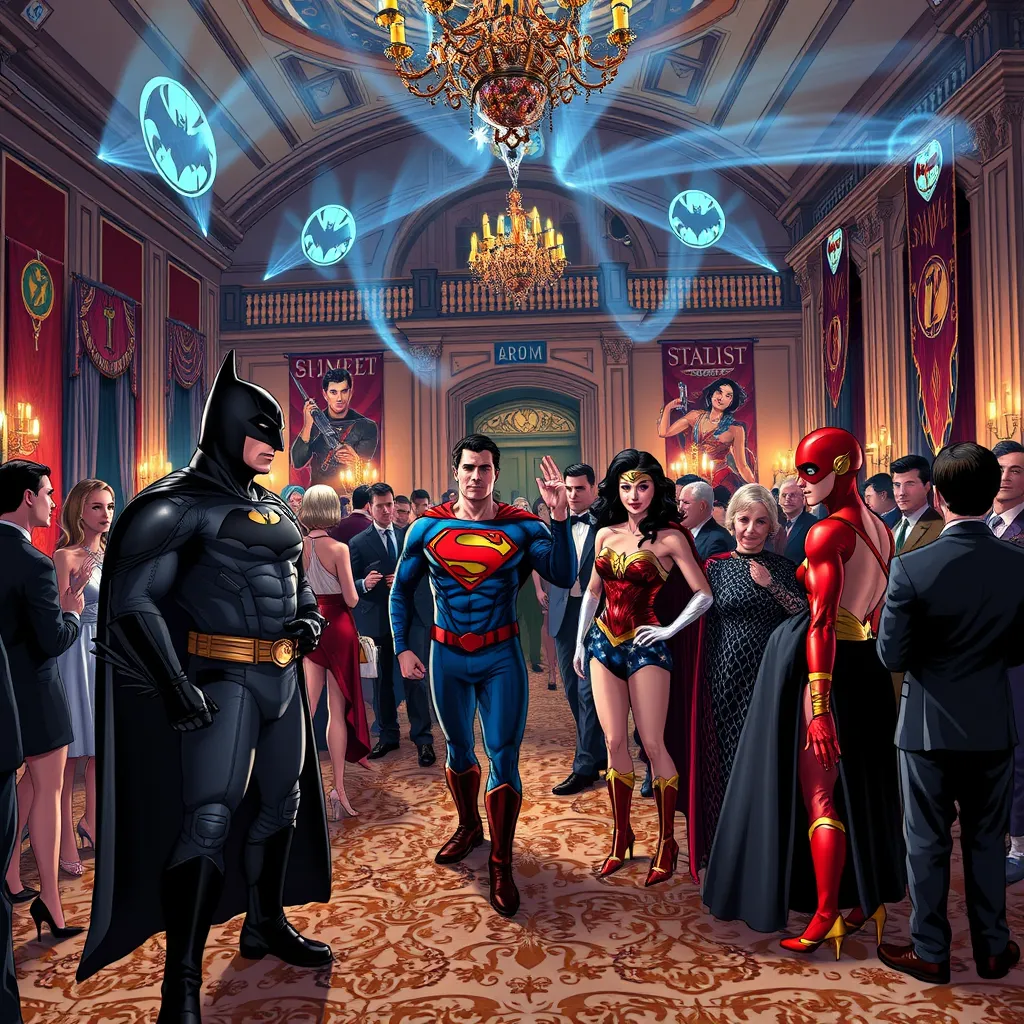

In [8]:
from PIL import Image as PILImage
import matplotlib.pyplot as plt

image_path = '/tmp/gradio/c200de34262db9ae45090488dd2d81451599b9cfbb3219ed3cb33f6f5658778e/image.webp'

img = PILImage.open(image_path)
img

## Importing a LangChain Tool

These tools need a [SerpApi API Key](https://serpapi.com/).

You can easily load LangChain tools using the `Tool.from_langchain()` method. Alfred, ever the perfectionist, is preparing for a spectacular superhero night at Wayne Manor while the Waynes are away. To make sure every detail exceeds expectations, he taps into LangChain tools to find top-tier entertainment ideas.

By using `Tool.from_langchain()`, Alfred effortlessly adds advanced search functionalities to his smolagent, enabling him to discover exclusive party ideas and services with just a few commands.

Here's how he does it:

In [10]:
!pip install langchain-community google-search-results

In [11]:
from google.colab import userdata
import os
os.environ["SERPAPI_API_KEY"] = userdata.get('SERPAPI_API_KEY')

In [13]:
from langchain.agents import load_tools
from smolagents import CodeAgent, HfApiModel, Tool

search_tool = Tool.from_langchain(load_tools(["serpapi"])[0])

agent = CodeAgent(tools=[search_tool], model=llm_model)

agent.run("Search for luxury entertainment ideas for a superhero-themed event, such as live performances and interactive experiences.")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Search for luxury entertainment ideas for a superhero-themed event, such as live performances and interactive   │
│ experiences.                                                                                                    │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  search_results = search(tool_input="luxury superhero event entertainment live performances interactive           
  experiences")                                                                                                    
  print(search_results)                                                                                            
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
['Each package includes balloons, games, and puppets. The premium and classic packages go the extra mile with a 
magic show and an interactive superhero disco, ...', 'Book this incredible superhero circus show with cosplay 
aerialists, villainous contortionist and much more. Available to book for events worldwide.', 'We specialize in 
immersive storytelling, interactive performances, and high-end character experiences that make every princess 
party, superhero appearance, and ...', 'Interactive Entertainment. Engage in action-packed activities, thrilling 
photo ops, and dynamic performances that bring superhero stories to life. Versatile ...', 'They\'ll have an answer 
for any question, can sign autographs, pose for pictures, even conduct a "superhero training" class for your 
guests!', 'Enjoy thrilling activities and one-of-a-kind entertainment—available on select 5-night cruises from Fort
Lauderdale to The Bahamas and Western Caribbean ...', 'Interactive Q&A: Organize a Q&A session with Marvel 
enthusiasts or invite comic book experts to share interesting trivia and behind-the-scenes stories. Include ...', 
'We designed & produced multiple themed interactive activations & media zones for this Superhero themed event for a
biotech company. Our Experiential ...', 'The leading interactive character performance company Here to bring 
kindness, magic, and interactive fun to your next big event in FL, CO, and PA!', 'Our professional performers are 
ready to create unforgettable moments through interactive meet-and-greet experiences.']

Out: None

[Step 1: Duration 2.61 seconds| Input tokens: 2,246 | Output tokens: 80]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  search_results_refined = search(tool_input="luxury superhero event entertainment ideas 'stunt show' 'aerial      
  performance' 'interactive art' 'virtual reality' 'augmented reality'")                                           
  print(search_results_refined)                                                                                    
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
['Ready to explore some of the most in-demand superhero party ideas? Below you can find a few of the most popular 
characters for heroes and villains parties.', 'We have a wide range of Sci-Fi Themed entertainment available based 
around science fiction themed entertainers for all your Sci-Fi themed event needs.', 'Icarus Flight Simulator 
boasts the ultimate event entertainment as guests soar through the sky playing games and winning prizes.', 'For the
Superhero theme, we proposed numerous different interactive stations staffed by favorite heroes. For instance, we 
offered Lasso Lessons with Wonder ...', 'In this post, we’ll share practical tips for choosing and implementing 
event themes, and provide real-world examples to show you how it can be done.', 'From DeLaGuarda, Fuerza Bruta, 
Pilobolus, and more, these artists create visionary aerial immersive entertainment, either as a wall dance and/or 
show for an ...', 'Aerial dancers and acrobats are perfect for weddings, galas, corporate events, private parties, 
and special events.', 'Dreamachine, which creates kaleidoscopic patterns that induce a dream-like state in the 
viewer. The exhibition ends with a look at some of the earliest artistic ...', 'interactive experiences such as 
virtual reality simula- tions or stargazing activities. Incorporate elements of popular sci-fi franchises ...']

Out: None

[Step 2: Duration 8.19 seconds| Input tokens: 4,958 | Output tokens: 209]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("Luxury entertainment ideas for a superhero-themed event include: superhero circus show, immersive  
  storytelling, interactive performances with meet-and-greets, stunt shows, aerial performances (aerial dancers    
  and acrobats), virtual reality simulations, interactive art installations, superhero training classes, and Q&A   
  sessions with comic book experts.")                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Luxury entertainment ideas for a superhero-themed event include: superhero circus show, 
immersive storytelling, interactive performances with meet-and-greets, stunt shows, aerial performances (aerial 
dancers and acrobats), virtual reality simulations, interactive art installations, superhero training classes, and 
Q&A sessions with comic book experts.

[Step 3: Duration 1.47 seconds| Input tokens: 8,183 | Output tokens: 336]

'Luxury entertainment ideas for a superhero-themed event include: superhero circus show, immersive storytelling, interactive performances with meet-and-greets, stunt shows, aerial performances (aerial dancers and acrobats), virtual reality simulations, interactive art installations, superhero training classes, and Q&A sessions with comic book experts.'

With this setup, Alfred can quickly discover luxurious entertainment options, ensuring Gotham's elite guests have an unforgettable experience. This tool helps him curate the perfect superhero-themed event for Wayne Manor! 🎉

In [11]:
import os
from smolagents import ToolCollection, CodeAgent
from mcp import StdioServerParameters
from smolagents import HfApiModel


model = HfApiModel("Qwen/Qwen2.5-Coder-32B-Instruct")
type(llm_model)

server_parameters = StdioServerParameters(
    command="uvx",
    args=["--quiet", "pubmedmcp@0.1.3"],
    env={"UV_PYTHON": "3.12", **os.environ},
)

with ToolCollection.from_mcp(server_parameters, trust_remote_code=True) as tool_collection:
    agent = CodeAgent(tools=[*tool_collection.tools], model=llm_model, add_base_tools=True)
    agent.run("Please find a remedy for hangover.")

Exception in thread Thread-12 (_run_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/dist-packages/mcpadapt/core.py", line 191, in _run_loop
    self.loop.run_until_complete(self.task)
  File "/usr/lib/python3.11/asyncio/base_events.py", line 654, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/mcpadapt/core.py", line 184, in setup
    async with mcptools(self.serverparams) as (session, tools):
  File "/usr/lib/python3.11/contextlib.py", line 210, in __aenter__
    return await anext(self.gen)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/mcpadapt/core.py", line 101, in mcptools
    async with client as (read, write):
  File "/usr/lib/python3.11/contextlib.py

TimeoutError: Couldn't connect to the MCP server after 30 seconds